In [13]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

# create dataset and dataloaders
dataset = create_qm9_mixture_vae_dataset(
    device=device, 
    include_hydrogen=include_hydrogen,
    refresh_data_cache=False,
    properties=None,
    prop_norm_df=prop_norm_df
)
train_dataset, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 1
train_loader = DataLoader(train_dataset[:1], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
train_batch = next(iter(train_loader))
train_batch

DataBatch(x=[9, 4], edge_index=[2, 22], edge_attr=[22, 4], y=[1, 19], pos=[20, 3], z=[20], smiles=[1], name=[1], idx=[1], batch=[9], ptr=[2])

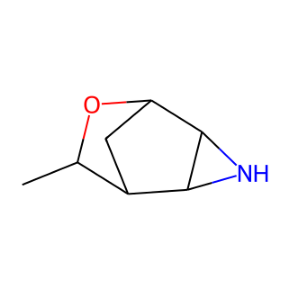

In [3]:
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
if batch_size > 1:
    axs = axs.flatten()

for i in range(len(train_batch)):
    batch_mask = train_batch.batch == i
    
    graph = train_batch[i]
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if batch_size > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")

plt.tight_layout()
plt.show()

# Decoder

In [15]:
import itertools
from typing import Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F


class MixtureModelDecoder(nn.Module):

    def __init__(self, hparams: Dict[str, Any]) -> None:
        super().__init__()

        num_clusters = hparams["num_clusters"]
        self.num_clusters = num_clusters
        latent_dim = hparams["latent_dim"]
        num_atom_types = hparams["num_atom_types"]
        num_bond_types = hparams["num_bond_types"] + 1  # +1 for non-existent bonds

        # model parameters
        self.eta_mu = nn.Parameter(torch.randn(1, num_clusters))
        self.eta_log_sigma = nn.Parameter(torch.randn(1, num_clusters))
        self.cluster_means = nn.Parameter(torch.randn(1, num_clusters, latent_dim))
        self.cluster_log_sigmas = nn.Parameter(torch.randn(1, num_clusters, latent_dim))
        self.atom_classifier = nn.Sequential(
            nn.Linear(latent_dim, num_atom_types),
            #nn.Softmax(dim=1)  # apply softmax in the loss
        )
        self.bond_matrix = nn.Parameter(torch.randn(1, num_bond_types, latent_dim, latent_dim))

        # TODO: anneal during training
        self.gumbel_softmax_temperature = 0.1

        # create edge indices of fully connected graph for all graph sizes up to 50
        self.edge_indices = []
        for N in range(2, 50):
            self.edge_indices.append(
                torch.tensor(list(itertools.combinations(range(N), 2)))
            )

    #def decode_eta(self, eta: torch.Tensor) -> torch.Tensor:
    
    def decode_z(self, z: torch.Tensor, num_atoms: torch.Tensor) -> Data:
        atom_types = self.atom_classifier(z)

        device = z.device
        
        # create edge indices of fully connected graphs
        edge_index_list = []
        offsets = torch.cat([torch.tensor([0], device=device), torch.cumsum(num_atoms, dim=0)[:-1]])
        for i, N in enumerate(num_atoms):
            pairs = self.edge_indices[N - 2].to(device)
            pairs += offsets[i]
            edge_index_list.append(pairs)

        edge_index = torch.cat(edge_index_list, dim=0)

        # make bond matrix symmetric to ensure permuation invariance
        W = (self.bond_matrix + self.bond_matrix.transpose(2, 3)) * 0.5

        z_pairs = z[edge_index].unsqueeze(-2).unsqueeze(-1)
        edge_type_logits = z_pairs[:, 0].permute(dims=(0, 1, 3, 2)) @ W @ z_pairs[:, 1]
        edge_types = F.softmax(edge_type_logits, dim=1).squeeze()

        edge_index = edge_index.t().contiguous()

        batch = torch.repeat_interleave(torch.arange(len(num_atoms), device=device), num_atoms)
        return Data(x=atom_types, edge_index=edge_index, edge_attr=edge_types, batch=batch)


    def forward(self, eta: torch.Tensor, num_atoms: torch.Tensor) -> Data:

        pi = F.softmax(eta, dim=1)
        log_pi = torch.log(pi)

        # sample clusters using the gumbel-softmax reparameterization
        c = F.gumbel_softmax(
            logits=torch.repeat_interleave(log_pi, num_atoms, dim=0),
            tau=self.gumbel_softmax_temperature,
            hard=True
        ).unsqueeze(-1)

        mu = torch.sum(self.cluster_means * c, dim=1)
        log_sigma = torch.sum(self.cluster_log_sigmas * c, dim=1)
        sigma = torch.exp(torch.clamp(log_sigma, -20, 30))

        z = torch.randn_like(mu) * sigma + mu

        return self.decode_z(z, num_atoms)


    def sample(self, num_atoms: torch.Tensor, device: str) -> Data:
        eta = torch.randn(size=(num_atoms.size(0), self.num_clusters), device=device)
        return self.forward(eta, num_atoms)

    

num_clusters = 16
hparams = {
    "num_clusters": num_clusters,
    "latent_dim": 2,
    "num_atom_types": dataset.num_node_features,
    "num_bond_types": dataset.num_edge_features,
}
print(hparams)

decoder_model = MixtureModelDecoder(hparams=hparams).to(device)

num_atoms = torch.tensor([3, 3], dtype=torch.int64, device=device)
data = decoder_model.sample(num_atoms, device)
data

{'num_clusters': 16, 'latent_dim': 2, 'num_atom_types': 4, 'num_bond_types': 4}


Data(x=[6, 4], edge_index=[2, 6], edge_attr=[6, 5], batch=[6])

In [16]:
def get_batch_item(batch_data: Data, i: int):
    node_mask = batch_data.batch == i

    offsets = torch.cumsum(torch.bincount(batch_data.batch), dim=0)

    edge_mask = (batch_data.edge_index[0] < offsets[i]) & (batch_data.edge_index[1] < offsets[i])
    if i > 0:
        edge_mask &= (batch_data.edge_index[0] >= offsets[i - 1]) & (batch_data.edge_index[1] >= offsets[i - 1])

    # remove non-existent edges
    edge_mask &= batch_data.edge_attr.argmax(dim=1) < 4
    edge_attr = batch_data.edge_attr[edge_mask][:,:-1]

    # adjust edge index based on batch index
    edge_index = batch_data.edge_index[:, edge_mask]
    if i > 0:
        edge_index -= offsets[i - 1]

    return Data(
        x=batch_data.x[node_mask],
        edge_index=edge_index,
        edge_attr=edge_attr
    )

get_batch_item(data, 1)

Data(x=[3, 4], edge_index=[2, 3], edge_attr=[3, 4])

# Encoder

In [17]:
from torch_geometric.nn import BatchNorm
from graph_vae.encoder import ECCConv, GlobalGraphPooling


class MixtureModelEncoder(nn.Module):

    def __init__(self, hparams: Dict[str, Any]) -> None:
        super().__init__()

        self.z_latent_dim = hparams["latent_dim"]
        self.eta_latent_dim = hparams["num_clusters"]

        channels = [16, 32, 64]

        module_list = [
            ECCConv(
                num_edge_features=hparams["num_bond_types"],
                in_channels=hparams["num_atom_types"],
                out_channels=channels[0]
            ),
            BatchNorm(in_channels=channels[0]),
            nn.PReLU()
        ]
        for i in range(len(channels) - 1):
            module_list.extend([
                ECCConv(
                    num_edge_features=hparams["num_bond_types"],
                    in_channels=channels[i],
                    out_channels=channels[i + 1]
                ),
                BatchNorm(in_channels=channels[i + 1]),
                nn.PReLU()
            ])

        self.gnn_layers = nn.ModuleList(module_list)
        self.z_head = nn.Linear(channels[-1], self.z_latent_dim * 2)

        self.graph_pooling = GlobalGraphPooling(in_channels=channels[-1], out_channels=channels[-1])
        self.eta_head = nn.Linear(in_features=channels[-1], out_features=self.eta_latent_dim * 2)
        

    def forward(self, data: Data) -> Tuple[torch.Tensor, torch.Tensor]:
        x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

        for layer in self.gnn_layers:
            if isinstance(layer, ECCConv):
                x = layer(x, edge_index, edge_attr)
            else:
                x = layer(x)

        z = self.z_head(x)

        z_mu = z[:, :self.z_latent_dim]
        z_log_sigma = z[:, self.z_latent_dim:]
        z_sigma = torch.exp(torch.clamp(z_log_sigma, -20, 30))

        eta = self.eta_head(self.graph_pooling(x, batch))

        eta_mu = eta[:, :self.eta_latent_dim]
        eta_log_sigma = eta[:, self.eta_latent_dim:]
        eta_sigma = torch.exp(torch.clamp(eta_log_sigma, -20, 30))

        return z_mu, z_sigma, eta_mu, eta_sigma

In [33]:
def kl_divergence_gaussian(mu_q, sigma_q, mu_p, sigma_p):
    """
    KL(q||p)
    """
    return (torch.log(sigma_p / sigma_q) + ((sigma_q ** 2 + (mu_q - mu_p) ** 2)) / (2 * sigma_p ** 2) - 0.5).sum(dim=1).mean()



encoder_model = MixtureModelEncoder(hparams=hparams).to(device)
decoder_model = MixtureModelDecoder(hparams=hparams).to(device)


epochs = 2000
optimizer = torch.optim.Adam(params=list(encoder_model.parameters()) + list(decoder_model.parameters()), lr=1e-3, weight_decay=1e-5)

encoder_model.train()
decoder_model.train()

loss_vals = []

for epoch in tqdm(range(epochs)):

    train_batch = next(iter(train_loader))

    optimizer.zero_grad()
    
    train_z_mu, train_z_mu_sigma, train_eta_mu, train_eta_sigma = encoder_model(train_batch)
    train_z = torch.randn_like(train_z_mu) * train_z_mu_sigma + train_z_mu
    train_num_atoms = torch.bincount(train_batch.batch)
    train_reconstruction = decoder_model.decode_z(train_z, train_num_atoms)
    train_target_x = torch.argmax(train_batch.x, dim=1)

    # atom reconstruction loss
    loss = F.cross_entropy(input=train_reconstruction.x, target=train_target_x, reduction="sum")

    # eta KL-Divergence
    eta_kl_divergence = kl_divergence_gaussian(
        mu_q=train_eta_mu,
        sigma_q=train_eta_sigma,
        mu_p=decoder_model.eta_mu,
        sigma_p=torch.exp(torch.clamp(decoder_model.eta_log_sigma, -20, 30))
    )
    #print(eta_kl_divergence)
    loss += eta_kl_divergence

    # TODO: cluster KL-Divergence    

    # TODO: z KL-Divergence

    # TODO: bond reconstruction loss

    
    loss /= len(train_batch)

    loss.backward()
    optimizer.step()

    loss_vals.append(loss.item())


encoder_model.eval()
decoder_model.eval()

100%|██████████| 2000/2000 [00:34<00:00, 58.34it/s]


MixtureModelDecoder(
  (atom_classifier): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
  )
)

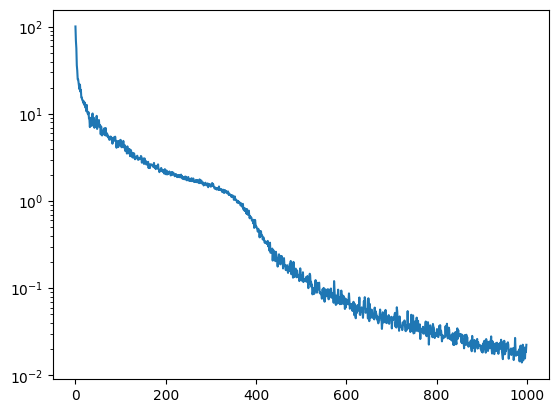

In [ ]:
plt.plot(loss_vals)
plt.yscale("log")
plt.show()

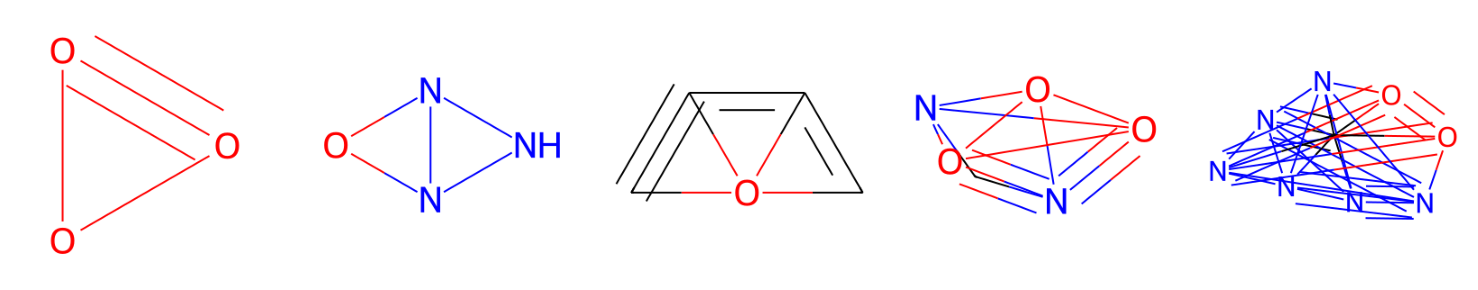

In [105]:
num_atoms = torch.tensor([3, 4, 5, 6, 9], dtype=torch.int64, device=device)
data = decoder_model.sample(num_atoms, device)

num_molecules = len(num_atoms)

fig, axs = plt.subplots(1, num_molecules, figsize=(num_molecules * 3, 3))
if num_molecules > 1:
    axs = axs.flatten()

for i in range(num_molecules):
    graph = get_batch_item(data, i)
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if num_molecules > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")


plt.tight_layout()
plt.show()